In [1]:
import glob as glob                                            # grabbing file names
import pandas as pd                                            # making dataframe for exporting parameters
import numpy as np                                             # basic math
import skimage.io as io                                        # reading in images
from skimage.measure import label, regionprops_table  # For labeling regions in thresholded images
import os
import trackpy as tp             # particle tracking toolbox
%matplotlib widget
import matplotlib.pyplot as plt  # for plotting everything
from matplotlib import cm, colors
from tcell_migration import *


/var/folders/qh/qtnhpk3n0wz437fnzt3vhrw00000gp/T/ipykernel_93334/3360651260.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd                                            # making dataframe for exporting parameters


In [2]:
# file name of the tracked data
filename = 'github_test/position_1/Position_1.tif'
track_filename = filename[:-4] + '_trackdata.h5'

# parameters needed for analysis
um_per_pix = 1.1
motile_displacement_minimum = 10  # in microns
overlap_displacement_minimum = 10  # in microns

In [3]:
# read in the dataframe with all the track data
track_data = pd.read_hdf(track_filename)

# extract the condition from the filename
condition = get_condition(track_filename)

# filter the track to get rid of non-motile cells
filtered_track_data = track_data[track_data.displacement > motile_displacement_minimum]
filtered_track_data_2 = filtered_track_data.reset_index()
# count the number of motile cells
N_motile_cells = len(filtered_track_data_2)


In [4]:
# get the IDs of the tracks
labels = filtered_track_data_2.index.values
# make an empty data frame to hold the data
all_data = pd.DataFrame()

# loop through each track
for counter,id_A in enumerate(labels):
    # get the trackA details
    trackA_x, trackA_y, trackA_frames, trackA_velocity = get_track_details(filtered_track_data_2, id_A)
    # compare each track to every other track permutations
    for id_B in labels[counter+1:]:
        # get the trackB details
        trackB_x, trackB_y, trackB_frames, trackB_velocity = get_track_details(filtered_track_data_2, id_B)
        # calculate the distance between points in the track
        track_distance_map = make_distance_map(trackA_x, trackA_y, trackB_x, trackB_y, gap = 2)
        # if there is overlap
        if np.sum(track_distance_map):
            # correct the track mask to connect small gaps in the overlap
            track_distance_mask, track_overlap_df = correct_track_distance_map(track_distance_map, gap = 2, min_area =3)
            # pull data about the overlapping region
            track_overlap_df = update_overlap_df(track_overlap_df, id_A,trackA_x, trackA_y, trackA_frames, trackA_velocity, id_B, trackB_x, trackB_y, trackB_frames, trackB_velocity)
            # add all this to the dataframe
            all_data = pd.concat([all_data, track_overlap_df], ignore_index=True)

# add a column to the dataframe with the condition and the filename
all_data['condition'] = [condition[-1]] * len(all_data)
all_data['filename'] = [track_filename] * len(all_data)


In [5]:
# Save the dataframe
all_data.to_hdf(track_filename[:-4] + '_overlap_data.h5', key='tracks', mode='w')


In [6]:
# filter the data frame to keep overlaps longer than the minimum
all_data_filtered = all_data[all_data.tA_length > overlap_displacement_minimum]
all_data_filtered = all_data_filtered[all_data_filtered.tB_length > overlap_displacement_minimum]


In [7]:
# save the filtered dataframe
all_data_filtered.to_hdf(track_filename[:-4] + '_filtered_overlap_data.h5', key='tracks', mode='w')

In [8]:
# find the total number of overlaps identified
N_overlaps = len(all_data_filtered)
# find valid track ids to keep
valid_ids = np.unique(np.concatenate([all_data_filtered.leader_id.values,all_data_filtered.follower_id.values]).astype('int'))
# find the numer of cells involved in those overlaps
N_valid_tracks = len(valid_ids)
# find the number of followers
N_followers = len(np.unique(all_data_filtered.follower_id.values))
# calculate averages of the groups 
mean_follower = np.mean(all_data_filtered.follower_velocity.values)
mean_leader = np.mean(all_data_filtered.leader_velocity.values)
mean_difference = np.mean(all_data_filtered.velocity_difference.values)

In [9]:
print(f'There are {N_motile_cells} motile cells with paths longer than {motile_displacement_minimum} in the dataframe')
print(f'There are {N_overlaps} overlaps identified longer than {overlap_displacement_minimum} um')
print(f'There are {N_followers} cells that follow another cell tracks')
print(f'The average velocities of the cells are:\n Mean Leader Velocity {mean_leader}\n Mean Follower Velocity {mean_follower}')

There are 605 motile cells with paths longer than 10 in the dataframe
There are 657 overlaps identified longer than 10 um
There are 279 cells that follow another cell tracks
The average velocities of the cells are:
 Mean Leader Velocity 0.171646420398501
 Mean Follower Velocity 0.19555645635917224


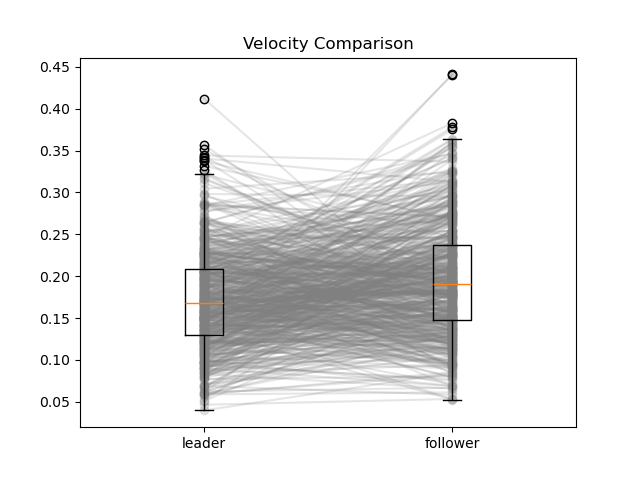

first track 0.171646420398501 +/- 0.05864733045422049
second track 0.19555645635917224 +/- 0.06747876033699692


In [10]:
all_velocities = [all_data_filtered.leader_velocity,all_data_filtered.follower_velocity]
# velocities2 = [overlap_data.track1_mean_velocity]

plt.figure()
for (v0,v1) in zip(all_data_filtered.leader_velocity,all_data_filtered.follower_velocity):
    plt.plot([1,2],[v0,v1],'o-', color='gray', alpha=0.2)
plt.boxplot(all_velocities, labels=['leader', 'follower'])
# plt.violinplot(velocities)
plt.title('Velocity Comparison')
plt.show()
print('first track {0} +/- {1}'.format(np.mean(all_data_filtered.leader_velocity),np.std(all_data_filtered.leader_velocity)))
print('second track {0} +/- {1}'.format(np.mean(all_data_filtered.follower_velocity),np.std(all_data_filtered.follower_velocity)))


In [ ]:
# make a movie of just the overlapping cells
# reduce the filtered track dataframe to keep only those tracks that have an overlap
overlapping_cell_tracks = filtered_track_data_2.loc[valid_ids]
# read in the image stack
imstack = io.imread(filename)
# make a movie with the overlaps on top 
make_movie_with_overlays(filename, imstack, overlapping_cell_tracks, im_min_inten=87, im_max_inten=591, color_hue='average_velocity', savename='validoverlaps')
